**Example of Calculating Yw and YG Temporal Trend**

Data utilized is from USDA NASS County-level Reports, Crop Performance Trials, NSP Yield Contest. Data was processed to pair growing season precipitation with yield observations.

In [89]:
import pandas as pd   
import matplotlib.pyplot as plt             
from yg_functions import*

In [218]:
# Read in processed files

# C is Combined USDA county yields with GSR for the NC, C, and SC Districts
C = pd.read_csv(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp\yield_gap_paper\sorghum_water_gap_paper\github\yg\\C.csv') 

# C_y is Combined yield contest, crop performance and USDA county yields with GSR for the NC, C, and SC Districts
C_y = pd.read_csv(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp\yield_gap_paper\sorghum_water_gap_paper\github\yg\\C_y.csv') 

# C_ is Combined yield contest, crop performance and USDA county yields with GSR for the C District
C_ = pd.read_csv(r'C:\Users\Sarah\OneDrive - Kansas State University\Desktop\scripts_jp\yield_gap_paper\sorghum_water_gap_paper\github\yg\\C_.csv') 

In [219]:
# Calculate Yw
Cmodel = CB_Percentile_Model(C_, C_.precip, C_.yield_kg_ha, 99) # Fit a Frontier Curve
cobb_douglas = lambda x, a, b, c: a + b * np.log(x) + c * np.log(x)**2 # define lambda function for cobb_douglas  
print("Yw for Central District is", np.round(cobb_douglas(355, *Cmodel[5]),0)) #Identify Yw at median precip (355 mm) w/fitted curve

Yw for Central District is 10.0


In [220]:
# Timeseries for Yc, Ya
c_yc = []
c_ya = []
c_gsr =[]

str_yr_ = np.arange(1980, 2012)
end_yr_ = np.arange(1989, 2021)

for s,e in zip(str_yr_,end_yr_):
    df = C.loc[(C.Year >=s) & (C.Year <e)]
    median_precip=df.precip.median()  # Typical Precip
    current_yield =  df.YIELD.median()
    Cmodel = CB_Percentile_Model(df, df.PRECIP, df.YIELD, 99) #!    
    yield_attainable = cobb_douglas(median_precip, *Cmodel[5])

    df.precip.median()
    c_yc.append(current_yield) 
    c_ya.append(yield_attainable)
    c_gsr.append(median_precip)

In [221]:
# Timeseries for Yw
c_yw =[]
max_yield_c= []

str_yr_ = np.arange(1980, 2012)
end_yr_ = np.arange(1989, 2021)
switch = []


for s,e,p in zip(str_yr_,end_yr_,c_gsr):
    C_yr = C_y.loc[(C_y.Year >=s) & (C_y.Year <e)]
    Cmodel = CB_Percentile_Model(C_yr, C_yr.PRECIP, C_yr.YIELD, 99) #!
    yield_w = cobb_douglas(p, *Cmodel[5])
    dumpy = np.where(Cmodel[1] == np.inf, 0, Cmodel[1]  )
    dumpy = np.where(Cmodel[0] <200, 0, dumpy) # set values for less than 200 mm to 0 
    dumpy = np.where(Cmodel[0] >p, 0, dumpy) # set values for less than 200 mm to 0 
    inde= np.nanargmax(dumpy) 
    maxiprec = Cmodel[0][inde]
    prec_boolean = maxiprec < p
    maxyield = Cmodel[1][inde]
    max_yield_c.append(maxyield)
    c_yw.append(yield_w)
    switch.append(prec_boolean) # if yield is higher at a point before GSR, switch to that point 

c_yw  = np.where(np.array(switch) == True , max_yield_c, c_yw)  

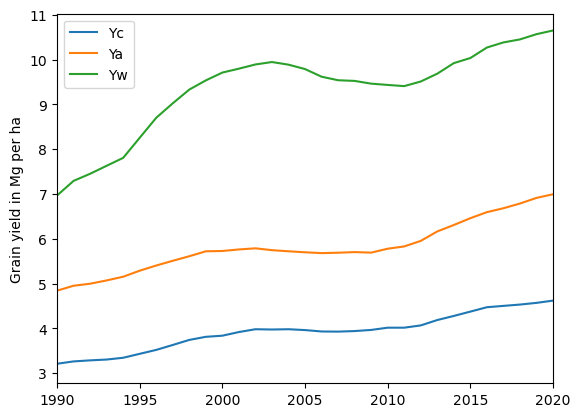

In [222]:
# Plot timeseries

central_= pd.DataFrame(
    {'yr': end_yr_,
     'yc': c_yc,
     'ya': c_ya,
     'yw':  c_yw,
    })

#West
plt.plot(central_.yr, central_['yc'].rolling(window=10,
                                       center=True,
                                       min_periods=5).mean().values, label = 'Yc')

plt.plot(central_.yr, central_['ya'].rolling(window=10,
                                       center=True,
                                       min_periods=5).mean().values,  label = 'Ya')

plt.plot(central_.yr, central_['yw'].rolling(window=10,
                                       center=True,
                                       min_periods=5).mean().values,  label = 'Yw')
plt.xlim(1990,2020)
plt.ylabel('Grain yield in Mg per ha')

plt.legend()